# Conclusion

In [1]:
# https://github.com/HideOnHouse/TorchBase

import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE

from dataset import *
from model import get_Model
from learning import *
from inference import *

torch.__version__

'1.11.0+cu102'

In [2]:
def label2int(data, label_tags):
    for i in range(len(data)):
        data.iloc[i,1] = label_tags.index(data.iloc[i, 1])
    return data


def draw_history(history):
    train_loss = history["train_loss"]
    train_acc = history["train_acc"]
    valid_loss = history["valid_loss"]
    valid_acc = history["valid_acc"]

    plt.subplot(2,1,1)
    plt.title("Loss")
    plt.plot(train_loss, label="train")
    plt.plot(valid_loss, label="valid")
    plt.legend()

    plt.subplot(2,1,2)
    plt.title('Accuracy')
    plt.plot(train_acc, label="train")
    plt.plot(valid_acc, label="valid")
    plt.legend()

    plt.show()

In [107]:
def get_cluster(model, device, loader, tsne):
    results = []
    labels = []

    model.to(device); model.eval()
    with torch.no_grad():
        for input_ids, att_mask, label in loader:
            input_ids, att_mask = input_ids.to(device), att_mask.to(device)
            _, embed = model(input_ids, att_mask)
            results.append(embed.cpu().numpy())
            labels.append(label)
    results = np.concatenate(results)
    _, labels = torch.max(torch.tensor(np.concatenate(labels)), dim=-1)
    labels = labels.numpy()

    embed_2d = tsne.fit_transform(results)
    
    return embed_2d, labels


def draw_cluster(model_path, device, bert_loader, roberta_loader, title, plt_shape=(2,6)):
    label_tags = ['불안', '슬픔', '기쁨']
    r, c, idx = plt_shape[0], plt_shape[1], 1
    
    plt.figure(figsize=(30,12), facecolor='azure')
    for y in range(r):
        for x in range(c):
            tsne = TSNE(n_components=2, learning_rate='auto', init='random')
            
            model = torch.load(f"models/"+model_path[y][x])
            loader = bert_loader if 'BERT' in model_path[y][x] else robert_loader

            embed_2d, labels = get_cluster(model, device, loader, tsne)
            
            plt.subplot(r,c,idx)
            for label in np.unique(labels):
                tmp = embed_2d[labels==label]
                plt.scatter(tmp[:,0], tmp[:,1], label=label_tags[label])
            plt.title(title[y][x])
            plt.legend()
            idx += 1
            
    plt.savefig('Check_cluster.png')
    plt.show()

In [97]:
def draw_total(path_list, legend_labels):    
    plt.figure(figsize=(16,6))    
    for path, labels in zip(path_list, legend_labels):
        with open('models/'+path, 'rb') as f:
            data = pickle.load(f)
            valid_loss = data["valid_loss"]
            valid_acc = data["valid_acc"]

            plt.subplot(1,2,1)
            plt.title("Loss")
            plt.plot(valid_loss, label=labels)
            plt.legend()

            plt.subplot(1,2,2)
            plt.title('Accuracy')
            plt.plot(valid_acc, label=labels)
            plt.legend()

    plt.show()

In [5]:
# label_tags
label_tags = ['불안', '슬픔', '기쁨']

test_path = "test.csv"
test_data = pd.read_csv(test_path)
test_data = label2int(test_data, label_tags)

# your Data Pre-Processing
test_x, test_y = test_data.iloc[:, :1], test_data.iloc[:, 1:]

# Check Train, Valid, Test Image's Shape
print("The Shape of Test Input: ", test_x.shape)

# Check Train, Valid Label's Shape
print("The Shape of Valid Labels: ", test_y.shape)

bert_path = "klue/bert-base"
roberta_path = "klue/roberta-base"

test_dataset_bert = MyDataset(test_x, test_y, model_path=bert_path)
test_dataset_roberta = MyDataset(test_x, test_y, model_path=roberta_path)

bert_loader = DataLoader(test_dataset_bert, batch_size=32)
roberta_loader = DataLoader(test_dataset_roberta, batch_size=32)

device = 'cuda' if torch.cuda.is_available() else 'cpu'
criterion = nn.CrossEntropyLoss()

The Shape of Test Input:  (100, 1)
The Shape of Valid Labels:  (100, 1)


In [54]:
model_path = [['MyModel_1_BERT.pt', 'MyModel_2_BERT.pt', 'MyModel_3_BERT.pt', 'MyModel_4_BERT.pt', 'MyModel_5_BERT.pt', 'MyModel_6_BERT.pt'],
              ['MyModel_1_RoBERTa.pt', 'MyModel_2_RoBERTa.pt', 'MyModel_3_RoBERTa.pt', 'MyModel_4_RoBERTa.pt', 'MyModel_5_RoBERTa.pt', 'MyModel_6_RoBERTa.pt']]

title = [['Basis BERT(CLS Token)', 'Basis BERT(Mean Pooling)', 'BERT(CLS) + Contrastive', 'BERT(Mean) + Contrastive', 'BERT(CLS) + Triplet', 'BERT(Mean) + Triplet'],
         ['Basis RoBERTa(CLS Token)', 'Basis RoBERTa(Mean Pooling)', 'RoBERTa(CLS) + Contrastive', 'RoBERTa(Mean) + Contrastive', 'RoBERTa(CLS) + Triplet', 'RoBERTa(Mean) + Triplet']]

In [6]:
display_result(device, criterion, bert_loader, roberta_loader)

Inference MyModel_1_BERT.pt
4it [00:00,  9.48it/s, loss=0.051182, acc=0.760]
	loss : 1.279549
	acc : 0.760


Inference MyModel_1_RoBERTa.pt
4it [00:00, 10.65it/s, loss=0.044404, acc=0.770]
	loss : 1.110098
	acc : 0.770


Inference MyModel_2_BERT.pt
4it [00:00, 10.03it/s, loss=0.058455, acc=0.780]
	loss : 1.461363
	acc : 0.780


Inference MyModel_2_RoBERTa.pt
4it [00:00, 10.79it/s, loss=0.036884, acc=0.740]
	loss : 0.922092
	acc : 0.740


Inference MyModel_3_BERT.pt
4it [00:00, 10.25it/s, loss=0.035573, acc=0.850]
	loss : 0.889334
	acc : 0.850


Inference MyModel_3_RoBERTa.pt
4it [00:00,  9.95it/s, loss=0.037755, acc=0.760]
	loss : 0.943865
	acc : 0.760


Inference MyModel_4_BERT.pt
4it [00:00, 10.64it/s, loss=0.048803, acc=0.780]
	loss : 1.220085
	acc : 0.780


Inference MyModel_4_RoBERTa.pt
4it [00:00,  9.75it/s, loss=0.032386, acc=0.760]
	loss : 0.809660
	acc : 0.760


Inference MyModel_5_BERT.pt
4it [00:00, 10.24it/s, loss=0.038801, acc=0.810]
	loss : 0.970025
	acc : 0.810


Inferen

/tmp/ipykernel_2796/426727646.py:43: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  plt.savefig('Check_cluster.png')
/opt/python/lib/python3.8/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


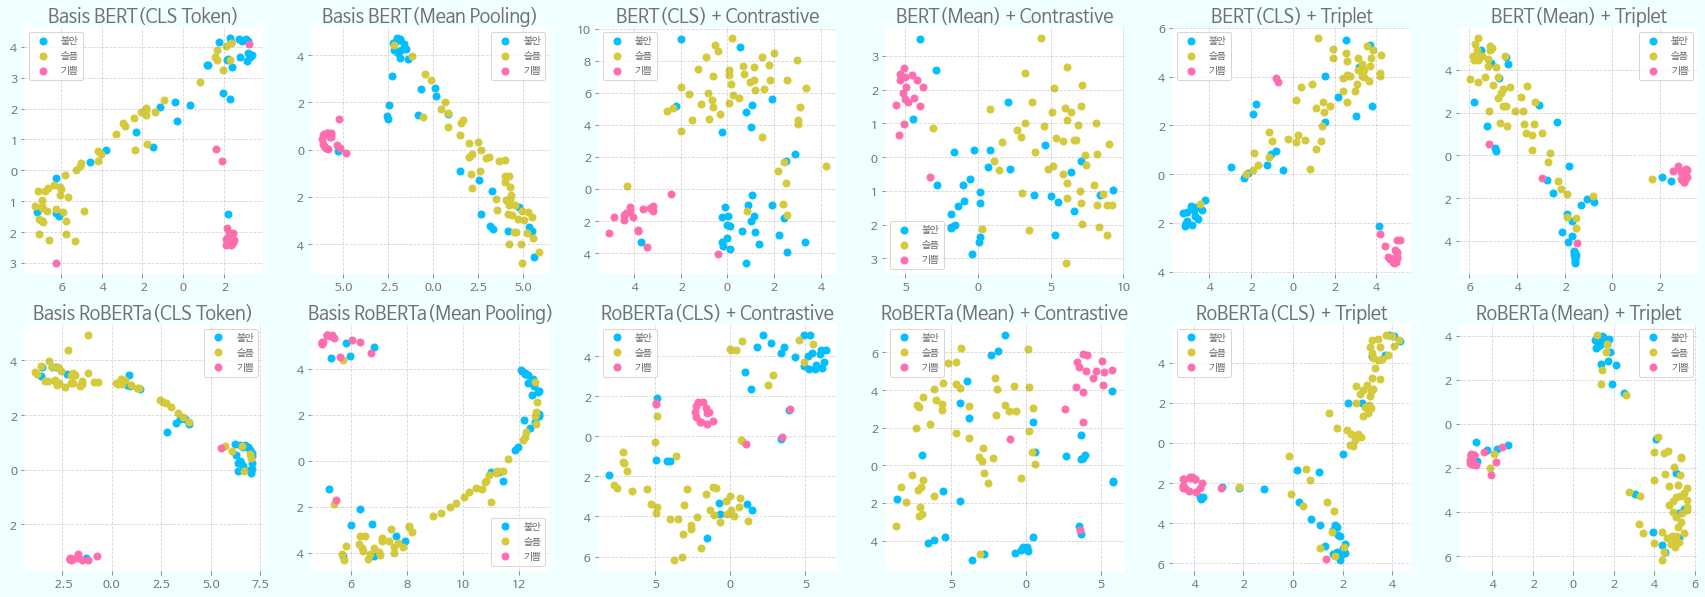

In [108]:
draw_cluster(model_path, device, bert_loader, roberta_loader, title, plt_shape=(2,6))

In [65]:
legend_labels = ['Model_{}_RoBERTa'.format(i+1) for i in range(6)]
legend_labels

['Model_1_RoBERTa',
 'Model_2_RoBERTa',
 'Model_3_RoBERTa',
 'Model_4_RoBERTa',
 'Model_5_RoBERTa',
 'Model_6_RoBERTa']

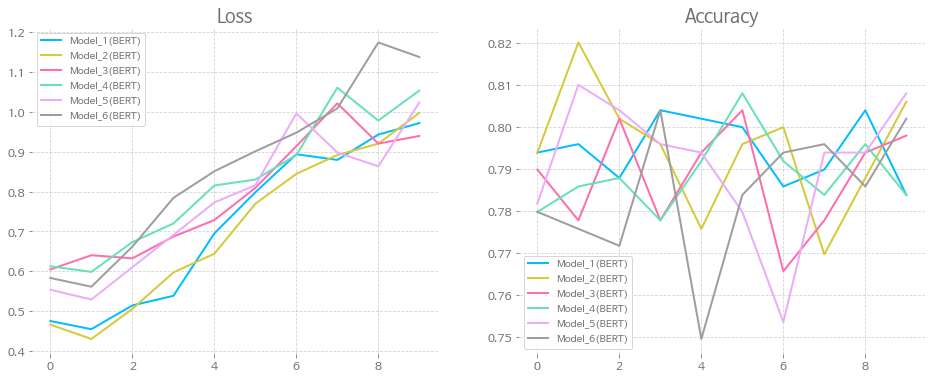

In [99]:
path_list = ['MyModel_1_BERT_history.pickle',
             'MyModel_2_BERT_history.pickle',
             'MyModel_3_BERT_history.pickle',
             'MyModel_4_BERT_history.pickle',
             'MyModel_5_BERT_history.pickle',
             'MyModel_6_BERT_history.pickle']
legend_labels = ['Model_1(BERT)',
                 'Model_2(BERT)',
                 'Model_3(BERT)',
                 'Model_4(BERT)',
                 'Model_5(BERT)',
                 'Model_6(BERT)',]

draw_total(path_list, legend_labels)

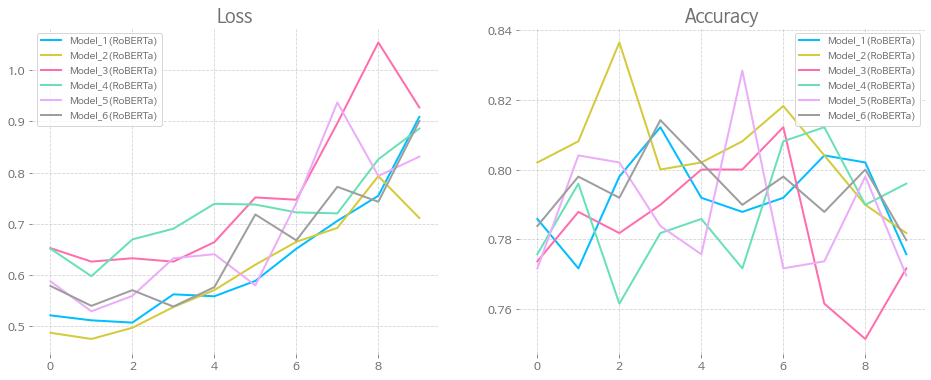

In [100]:
path_list = ['MyModel_1_RoBERTa_history.pickle',
             'MyModel_2_RoBERTa_history.pickle',
             'MyModel_3_RoBERTa_history.pickle',
             'MyModel_4_RoBERTa_history.pickle',
             'MyModel_5_RoBERTa_history.pickle',
             'MyModel_6_RoBERTa_history.pickle']
legend_labels = ['Model_1(RoBERTa)',
                 'Model_2(RoBERTa)',
                 'Model_3(RoBERTa)',
                 'Model_4(RoBERTa)',
                 'Model_5(RoBERTa)',
                 'Model_6(RoBERTa)']

draw_total(path_list, legend_labels)